# Introduction

This notebook contains the final stage code for my final year project. 

The main tasks completes:
- reads in the MIT-BIH Arrhythmia dataset, 
- splits it per heartbeat, 
- explores the data breifly, 
- trains a CNN model using the data,
- evaluates the model,
- converts into a TFlite model.

In [ ]:
%pip install wfdb numpy pandas matplotlib tensorflow imbalanced-learn seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import needed libraries
import os
import wfdb
import numpy as np
import pandas as pd

# Load data in from google drive
data = '/content/drive/MyDrive/mitdb1'

# Split each record in datasept
patients = [f.split('.')[0] for f in os.listdir(data) if f.endswith('.hea')]
patients = np.sort(patients)
labels_df = pd.DataFrame()

for pat_id in patients:
    file = os.path.join(data, pat_id)
    annotation = wfdb.rdann(file, 'atr')

    #sym is the annotated symbol read from the file
    labels = annotation.symbol

    #values is the different symbols in each patient
    #counts is the number of each symbol for said patient
    vals, cts = np.unique(labels, return_counts=True)

    #df_sub is a mini lil dataframe for each individual patient
    df_per_pat = pd.DataFrame({'Symbol':vals, 'Counts':cts, 'Patient':[pat_id]*len(cts)})
    labels_df = pd.concat([labels_df, df_per_pat],axis = 0)

labels_df.groupby('Symbol').Counts.sum().sort_values(ascending = False)

Symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

### Exploring each beat label shows there are 23 in total with varying amounts for each label, a clear immbalance is already spotted with the N class being huge.

In [ ]:
print(np.unique(labels_df.Symbol))
print(len(np.unique(labels_df.Symbol)))

['!' '"' '+' '/' 'A' 'E' 'F' 'J' 'L' 'N' 'Q' 'R' 'S' 'V' '[' ']' 'a' 'e'
 'f' 'j' 'x' '|' '~']
23


In [ ]:
# For first stage, consider N as normal heartbeats, all others are irregular or noise (according to found article).
other = ['/','f','j','a']
normal = ['N','L','R','e']
ventricular = ['V','E']
supraventricular = ['S','J','A','a']
fusion = ['F']

#AAMI_labels = [['N', 'L', 'R', 'e'], ['V', 'E'], ['S', 'J', 'A', 'a'], ['F'], ['/', 'f', 'j', 'a']]
#classes = [label for sublist in AAMI_labels for label in sublist]

AAMI_labels = [['N', 'L', 'R', 'e'], ['V', 'E'], ['S', 'J', 'A', 'a'], ['F'], ['/', 'f', 'j', 'a']]

# Define your classes
classes = ['Normal', 'Ventricular', 'Supraventricular', 'Fusion', 'Other']




In [ ]:
# used to load in the entire ECG dataset,
# get the signal and label,
# read the symbols and signal

def load_ecg(file):

    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal
    symbol_ann = annotation.symbol
    sample_ann = annotation.sample

    return p_signal, symbol_ann, sample_ann

In [ ]:
# creates dataset for model training

def make_dataset(patients, seconds, frequency, classes):

  #set number of data points
  columns = 2 * seconds * frequency
  data_X = np.zeros((1,columns))
  data_Y = np.zeros((1,len(classes)))
  data_Labels = []

  rows_per_patient = []

  for pat in patients:
    file = os.path.join(data, pat)
    p_signal, symbol_ann, sample_ann = load_ecg(file)

    # only using one lead for simplicity
    p_signal = p_signal[:,0]

    # make df without the noise symbols
    df_data = pd.DataFrame({'symbol_ann':symbol_ann, 'sample_ann':sample_ann})
    #df_data = df_data.loc[df_data.symbol_ann.isin(classes)]
    df_data['symbol_ann'] = df_data['symbol_ann'].apply(lambda x: next((class_name for class_name, label_list in zip(classes, AAMI_labels) if x in label_list), 'Other'))



    rows = len(df_data)
    X = np.zeros((rows, columns))
    Y = np.zeros((rows,len(classes)))
    symbs = []

    # keep track of rows
    maximum_rows = 0

    for sample_ann, symbol_ann in zip(df_data.sample_ann.values,df_data.symbol_ann.values):
        left = max([0,(sample_ann - seconds * frequency) ])
        right = min([len(p_signal),(sample_ann + seconds * frequency) ])
        x = p_signal[left: right]
        if len(x) == columns:
            X[maximum_rows,:] = x
            class_index = classes.index(symbol_ann)
            Y[maximum_rows, class_index] = 1
            maximum_rows += 1

    X = X[:maximum_rows,:]
    Y = Y[:maximum_rows,:]

    data_Labels += df_data['symbol_ann'].tolist()
    data_X = np.append(data_X,X,axis = 0)
    data_Y = np.append(data_Y,Y,axis = 0)

  data_X = data_X[1:,:]
  data_Y = data_Y[1:,:]

  return data_X, data_Y, data_Labels

In [ ]:
X_data, Y_data, symbol_data = make_dataset(patients, 3, 360, classes)


In [ ]:
# Look at the balance of labels in the dataset

y_dataframe = pd.DataFrame(Y_data)

label_counts = y_dataframe.iloc[:, 0:].sum()
print(label_counts)

0    90098.0
1     7219.0
2     2771.0
3      801.0
4    11344.0
dtype: float64


### Condensed the labels into Classes and can see that the imbalance remains, but there is a large amount of data overall.

In [ ]:
# take a single sample to see how the label is encoded

print((Y_data[1000]))

[1. 0. 0. 0. 0.]


In [ ]:
from sklearn.model_selection import train_test_split

# splitting the dataset into training, validation and testing sets
# test sets remain untouched until after model training to evaluate fairly

X_train, X_temp, y_train, y_temp = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# convert the training set into a dataframe to visualise each record in a table

df4 = pd.DataFrame(X_train)

df4

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-0.825,-0.815,-0.805,-0.805,-0.795,-0.785,-0.760,-0.765,-0.740,-0.710,...,-0.520,-0.525,-0.525,-0.530,-0.540,-0.550,-0.550,-0.540,-0.545,-0.535
1,-0.370,-0.370,-0.365,-0.350,-0.335,-0.320,-0.300,-0.265,-0.255,-0.250,...,-0.265,-0.285,-0.300,-0.300,-0.295,-0.270,-0.255,-0.255,-0.250,-0.230
2,-0.225,-0.220,-0.215,-0.220,-0.235,-0.270,-0.270,-0.275,-0.265,-0.250,...,-0.340,-0.330,-0.320,-0.325,-0.335,-0.340,-0.330,-0.325,-0.315,-0.335
3,-0.260,-0.260,-0.270,-0.260,-0.250,-0.255,-0.245,-0.250,-0.255,-0.250,...,-0.375,-0.365,-0.360,-0.345,-0.330,-0.320,-0.310,-0.320,-0.310,-0.325
4,-0.640,-0.645,-0.640,-0.615,-0.600,-0.575,-0.580,-0.585,-0.585,-0.585,...,-0.880,-0.880,-0.885,-0.880,-0.880,-0.875,-0.870,-0.870,-0.880,-0.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78558,0.720,0.705,0.700,0.690,0.675,0.655,0.640,0.605,0.580,0.555,...,-0.670,-0.670,-0.675,-0.660,-0.655,-0.660,-0.675,-0.705,-0.715,-0.725
78559,-0.270,-0.275,-0.270,-0.270,-0.270,-0.255,-0.265,-0.255,-0.245,-0.255,...,-0.055,-0.055,-0.055,-0.040,-0.020,-0.030,-0.035,-0.040,-0.035,-0.040
78560,-0.165,-0.160,-0.175,-0.175,-0.175,-0.175,-0.175,-0.160,-0.170,-0.145,...,0.130,0.145,0.155,0.165,0.180,0.195,0.215,0.230,0.250,0.265
78561,0.100,0.340,0.615,0.870,0.990,0.995,0.835,0.520,0.100,-0.235,...,-0.520,-0.550,-0.535,-0.500,-0.385,-0.250,-0.100,0.080,0.310,0.590


In [ ]:
# print the shapes of each set to gather the amount of samples in each


print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(78563, 2160)
(78563, 5)
(16835, 2160)
(16835, 5)
(16835, 2160)
(16835, 5)


In [ ]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


print(X_train_cnn.shape)

(78563, 2160, 1)


In [ ]:
print(X_train_cnn.shape)
print(X_train_cnn[0].shape)
samp = X_train_cnn[3]

(78563, 2160, 1)
(2160, 1)


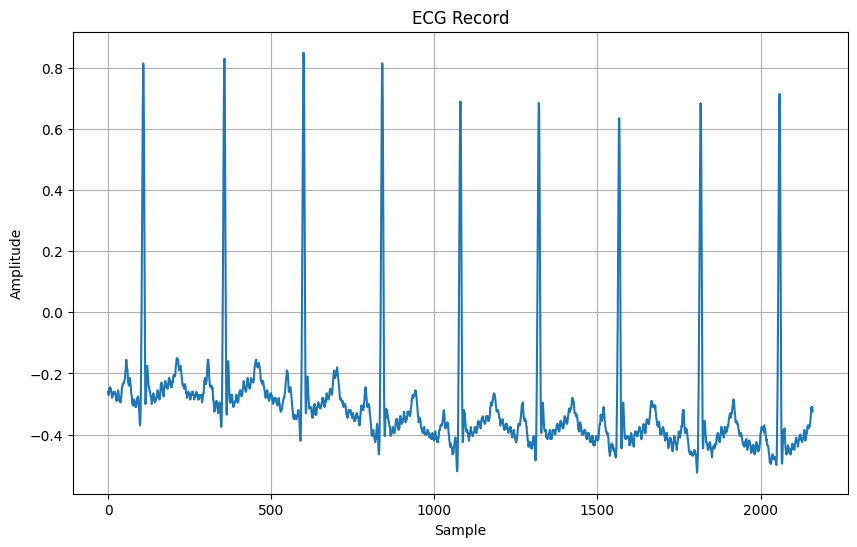

In [ ]:
import matplotlib.pyplot as plt


# plot a single sample while exploring data

plt.figure(figsize=(10, 6))
plt.plot(samp)
plt.title('ECG Record')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### It is a good idea to visualise the data points to form a sample and take a closer look at the data. This shows a single ECG beat record and is very stable which is expected from a Holter device.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


# building the CNN model for classification, scaled up incrementally

model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(2160,1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(classes), activation='softmax'))  # softmax for multiclass classification

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# train the model
model.fit(X_train_cnn, y_train, epochs=5, validation_data=(X_valid_cnn, y_valid))

# evaluate model on unseen test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2158, 64)          256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1079, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 1077, 128)         24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 538, 128)          0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 68864)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

### Here the overall structure of the model shows how large it has grown and it's performance during training.
### The final test accuracy is 98% which is very high but requires further evaluation.

527/527 [==============================] - 58s 110ms/step


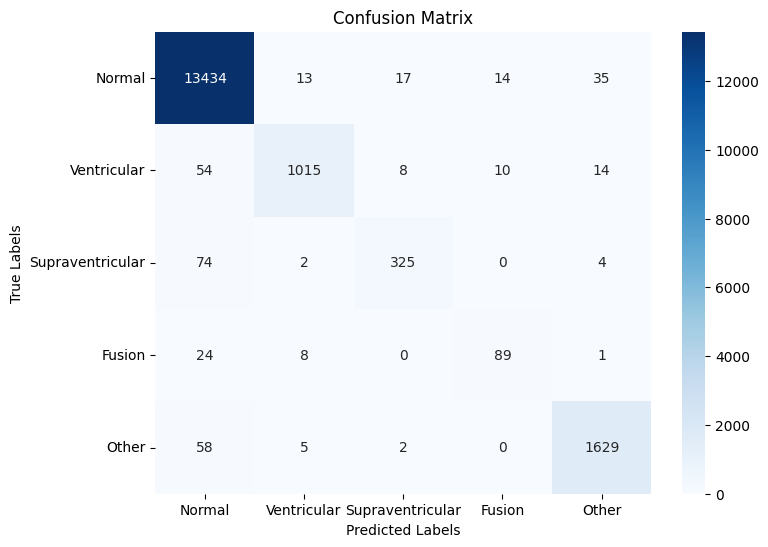

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_valid_classes = np.argmax(y_test, axis=1)

# calculate confusion matrix
conf_matrix = confusion_matrix(y_valid_classes, y_pred_classes)

# display confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Now it is possible to see every single prediciton made, it is clear that the model does well overall but there are some issues.
### Notably, alot of normal predictions are made where they shouldn't be.
### This might be due to the large proportion of data in the Normal class, causing it to become biased.

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_valid_classes, y_pred_classes, target_names=classes))


                  precision    recall  f1-score   support

          Normal       0.98      0.99      0.99     13513
     Ventricular       0.97      0.92      0.95      1101
Supraventricular       0.92      0.80      0.86       405
          Fusion       0.79      0.73      0.76       122
           Other       0.97      0.96      0.96      1694

        accuracy                           0.98     16835
       macro avg       0.93      0.88      0.90     16835
    weighted avg       0.98      0.98      0.98     16835



### Closer look at each individual class as a metric and the overall performance.
### Shows that Normal is much better.

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2158, 64)          256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1079, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 1077, 128)         24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 538, 128)          0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 68864)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
modelpath = ("./models/")
tf.saved_model.save(model,modelpath )

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFlite model to a file
with open('/content/drive/MyDrive/lighter_model.tflite', 'wb') as f:
    f.write(tflite_model)